# 1. Business Understanding

# Problem Statements

Pengguna platform layanan film sering kali kesulitan menemukan film yang sesuai dengan preferensi mereka karena banyaknya pilihan dan variasi konten yang tersedia. Hal ini menyebabkan pengalaman pengguna menurun dan potensi engagement yang rendah.

Selain itu, sistem rekomendasi yang ada belum mampu secara efektif menangani permasalahan seperti cold start dan keterbatasan data pengguna, sehingga rekomendasi yang diberikan kurang personal dan relevan.

## Goals

Proyek ini bertujuan untuk mengembangkan sistem rekomendasi film yang mampu memberikan rekomendasi Top-N yang relevan dan personal bagi setiap pengguna. Sistem ini harus mampu:

- Meningkatkan pengalaman pengguna dalam menemukan film yang sesuai selera.
- Mengatasi permasalahan cold start dan sparsity data dengan pendekatan yang tepat.
- Memberikan rekomendasi yang dapat dipertanggungjawabkan secara teknis dan praktis.

## Solution Approach

Dalam rangka mencapai tujuan tersebut, proyek ini menggunakan dua pendekatan utama sistem rekomendasi:

1. **Content-Based Filtering**  
   Pendekatan ini merekomendasikan film berdasarkan kesamaan fitur konten, seperti genre, yang sesuai dengan preferensi pengguna. Metode ini efektif untuk menangani cold start pada pengguna baru karena hanya membutuhkan data konten film.

2. **Collaborative Filtering**  
   Pendekatan ini menggunakan pola interaksi dan rating pengguna lain untuk memberikan rekomendasi. Metode ini dapat menangkap preferensi laten dan pola kompleks antar pengguna dan film, sehingga dapat memberikan rekomendasi yang lebih personal dan kontekstual.

Kombinasi kedua pendekatan ini diharapkan dapat saling melengkapi kekurangan masing-masing, sehingga menghasilkan sistem rekomendasi yang lebih robust dan efektif.

# 2. Data Understanding

Dataset yang digunakan dalam proyek ini adalah [MovieLens 100K](https://grouplens.org/datasets/movielens/100k/), yang merupakan dataset benchmark dalam penelitian sistem rekomendasi.

### Deskripsi Dataset

Dataset ini terdiri dari 100.000 interaksi (rating) dari 943 pengguna terhadap 1.682 film. Dataset ini disusun ke dalam beberapa file terpisah dengan format tab-delimited dan memiliki informasi sebagai berikut:

- `u.data`: data rating, berisi user ID, item ID (film), rating (1–5), dan timestamp.
- `u.item`: metadata film seperti judul, tanggal rilis, dan genre.
- `u.user`: data pengguna yang mencakup usia, jenis kelamin, pekerjaan, dan kode pos.
- `u.genre`: daftar genre film dan ID genre.

### Link Dataset
Dataset ini dapat diunduh secara resmi dari:  
[https://grouplens.org/datasets/movielens/100k/](https://grouplens.org/datasets/movielens/100k/)

### Fitur yang Digunakan
Beberapa fitur penting yang akan dianalisis:
- `user_id`: ID pengguna unik
- `item_id`: ID film
- `rating`: skor yang diberikan user terhadap film
- `title`: judul film
- `release_date`: tanggal rilis film
- `genre`: genre film (biner)

### Tujuan Eksplorasi Data
Tahapan ini bertujuan untuk memahami struktur data, kualitas data, serta pola umum dalam interaksi user-film. Analisis akan mencakup:
- Informasi dasar struktur dataset
- Statistik deskriptif
- Pemeriksaan missing values
- Distribusi rating
- Film terpopuler
- Aktivitas pengguna
- Visualisasi (histogram, boxplot, barplot)

In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from math import sqrt

**Import Libraries**

Langkah pertama dalam proses pengembangan sistem rekomendasi adalah mengimpor pustaka (libraries) yang dibutuhkan. Berikut penjelasan fungsi masing-masing pustaka yang digunakan:

- `pandas`: Digunakan untuk memuat dan memanipulasi dataset berbentuk tabel (DataFrame).
- `matplotlib.pyplot` dan `seaborn`: Pustaka visualisasi data untuk membuat grafik seperti histogram, boxplot, dan barplot.
- `numpy`: Pustaka fundamental untuk komputasi numerik, khususnya array dan operasi linier.

Dari Scikit-learn:
- `cosine_similarity`: Untuk menghitung kemiripan antar film berdasarkan genre (content-based filtering).
- `TruncatedSVD`: Digunakan untuk mengurangi dimensi matriks user-item, teknik ini merupakan dasar dari collaborative filtering berbasis matrix factorization.
- `mean_squared_error` dan `sqrt`: Digunakan untuk menghitung metrik evaluasi RMSE (Root Mean Square Error) sebagai pengukur performa prediksi rating.


In [2]:
# Load dataset utama
df_ratings = pd.read_csv("ml-100k/u.data", sep="\t", names=["user_id", "item_id", "rating", "timestamp"])

**Load Dataset Utama**

Langkah pertama dalam proses pemrosesan data adalah memuat dataset utama. File `u.data` merupakan bagian dari MovieLens 100K dataset yang berisi data interaksi antara pengguna dan film dalam bentuk rating.

Dataset ini memiliki format **tab-delimited** (dipisahkan oleh tab `\t`), dan setiap baris merepresentasikan satu interaksi, dengan struktur sebagai berikut:

- `user_id`: ID pengguna
- `item_id`: ID film
- `rating`: nilai rating yang diberikan (1–5)
- `timestamp`: waktu rating diberikan (dalam format UNIX epoch)


In [3]:
# Load item (film metadata)
df_items = pd.read_csv(
    'ml-100k/u.item',
    sep='|',
    encoding='latin-1',
    names=['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] + [f'genre_{i}' for i in range(19)],
    usecols=range(24)
)

**Load Metadata Film**

File `u.item` berisi metadata dari setiap film yang terdapat dalam dataset MovieLens 100K. Metadata ini mencakup informasi judul film, tanggal rilis, dan representasi biner genre.

Dataset ini dipisahkan oleh simbol `|` (pipe), sehingga perlu ditentukan pemisahnya saat pembacaan. Karena beberapa karakter dalam file menggunakan encoding khusus, digunakan parameter `encoding='latin-1'`.

Kolom-kolom yang dimuat antara lain:
- `item_id`: ID film
- `title`: judul film
- `release_date`: tanggal rilis film
- `video_release_date`: tanggal rilis versi video (umumnya kosong)
- `IMDb_URL`: link film ke IMDb
- `genre_0` sampai `genre_18`: representasi genre film dalam format biner (1 berarti film memiliki genre tersebut, 0 berarti tidak)


In [4]:
# Gabungkan data rating dan item
df = pd.merge(df_ratings, df_items[['item_id', 'title', 'release_date']], on='item_id')

**Gabungkan Data Rating dan Metadata Film**

Setelah memuat data interaksi pengguna (`df_ratings`) dan metadata film (`df_items`), langkah selanjutnya adalah menggabungkan kedua dataset tersebut untuk membentuk satu DataFrame yang komprehensif.

Penggabungan dilakukan berdasarkan kolom `item_id`, yang merupakan kunci utama (primary key) pada kedua tabel.

Kolom yang disertakan dari `df_items` dalam penggabungan ini adalah:
- `title`: judul film
- `release_date`: tanggal rilis film

Hasil penggabungan akan memudahkan analisis selanjutnya seperti menampilkan judul film dalam rekomendasi dan menganalisis perilaku pengguna berdasarkan waktu rilis film.


In [5]:
# Struktur & Statistik
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       100000 non-null  int64 
 1   item_id       100000 non-null  int64 
 2   rating        100000 non-null  int64 
 3   timestamp     100000 non-null  int64 
 4   title         100000 non-null  object
 5   release_date  99991 non-null   object
dtypes: int64(4), object(2)
memory usage: 5.3+ MB
None


**Pemeriksaan Struktur Data**

Untuk memahami struktur dan kualitas dataset setelah proses penggabungan, digunakan fungsi `df.info()` dari pandas. Fungsi ini memberikan informasi seperti:

- Jumlah total baris (entry)
- Nama kolom
- Jumlah nilai yang tidak kosong (non-null)
- Tipe data (data types)

**Output:**

- Dataset berisi **100.000 baris** (interaksi pengguna dengan film).
- Semua kolom memiliki 100.000 nilai **non-null**, kecuali kolom `release_date` yang memiliki 99.991 nilai, artinya ada **9 data yang kosong** pada tanggal rilis film.
- Tipe data:
  - `user_id`, `item_id`, `rating`, `timestamp`: integer
  - `title`, `release_date`: object (string)

In [6]:
print(df.describe())

            user_id        item_id         rating     timestamp
count  100000.00000  100000.000000  100000.000000  1.000000e+05
mean      462.48475     425.530130       3.529860  8.835289e+08
std       266.61442     330.798356       1.125674  5.343856e+06
min         1.00000       1.000000       1.000000  8.747247e+08
25%       254.00000     175.000000       3.000000  8.794487e+08
50%       447.00000     322.000000       4.000000  8.828269e+08
75%       682.00000     631.000000       4.000000  8.882600e+08
max       943.00000    1682.000000       5.000000  8.932866e+08


**Statistik Deskriptif**

Fungsi `df.describe()` digunakan untuk memberikan gambaran statistik ringkas dari kolom numerik dalam dataset. Informasi yang ditampilkan meliputi jumlah data (`count`), nilai rata-rata (`mean`), standar deviasi (`std`), nilai minimum (`min`), hingga kuartil 25%, 50% (median), 75%, dan nilai maksimum (`max`).

**Hasil Analisis:**

- **user_id**: Terdapat 943 pengguna unik (ID dari 1 hingga 943).
- **item_id**: Terdapat 1.682 film (ID dari 1 hingga 1682).
- **rating**:
  - Rata-rata rating: sekitar **3.53**
  - Rating minimum: **1**, maksimum: **5**
  - Mayoritas rating berada di antara **3 dan 4**, sesuai dengan persepsi umum bahwa pengguna cenderung memberikan rating menengah ke atas.
- **timestamp**:
  - Merupakan waktu rating dalam format UNIX timestamp.
  - Dapat dikonversi ke format waktu manusia (datetime) untuk analisis berbasis waktu (jika diperlukan).

/var/folders/nk/xlbwp6w12lj8dwv0ksf9flpm0000gn/T/ipykernel_63819/268797703.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')


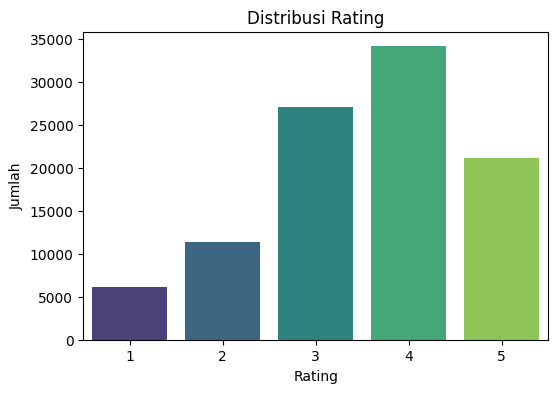

In [7]:
# Distribusi Rating
plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

**Insight: Distribusi Rating**

Berdasarkan visualisasi distribusi rating, terdapat beberapa insight penting yang dapat disimpulkan:

- **Rating 3 dan 4 mendominasi** dataset, menunjukkan bahwa sebagian besar pengguna cenderung memberikan penilaian netral hingga positif terhadap film yang mereka tonton.
- **Rating 1 dan 2 relatif jarang diberikan**, mengindikasikan bahwa pengguna cenderung menghindari memberi rating rendah kecuali untuk film yang sangat tidak disukai.
- **Rating 5 (tertinggi)** juga cukup umum, namun tidak sebanyak rating 4, yang mungkin mencerminkan bahwa pengguna lebih selektif saat memberikan rating maksimal.

Distribusi ini menunjukkan adanya **bias ke arah rating tinggi**, yang perlu diperhitungkan saat membangun model evaluasi maupun saat menentukan threshold relevansi untuk metrik seperti Precision@K.

/var/folders/nk/xlbwp6w12lj8dwv0ksf9flpm0000gn/T/ipykernel_63819/3435101554.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rating', data=df, palette='Set2')


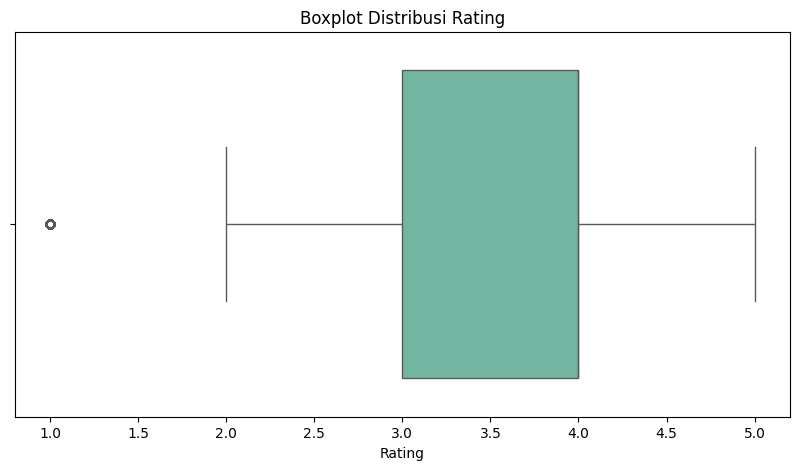

In [8]:
# Boxplot Rating per User
plt.figure(figsize=(10,5))
sns.boxplot(x='rating', data=df, palette='Set2')
plt.title('Boxplot Distribusi Rating')
plt.xlabel('Rating')
plt.show()


**Insight: Boxplot Distribusi Rating**

Visualisasi boxplot digunakan untuk melihat penyebaran nilai rating sekaligus mendeteksi adanya outlier.

Beberapa insight penting yang dapat diambil dari boxplot distribusi rating adalah:

- **Median rating berada pada angka 4**, artinya lebih dari 50% pengguna memberikan rating minimal 4.
- Sebagian besar rating berada pada rentang **antara 3 dan 4**, menunjukkan distribusi rating yang condong ke arah positif.
- **Rating 1 terlihat sebagai outlier**, mengindikasikan bahwa hanya sedikit pengguna yang memberikan rating sangat rendah.
- Tidak ditemukan outlier signifikan pada nilai rating tertinggi (5), memperkuat pola bahwa pengguna cenderung memberi rating yang baik.

Boxplot ini memperkuat temuan sebelumnya dari histogram bahwa dataset ini memiliki **skew ke arah rating tinggi**, yang perlu dipertimbangkan dalam penyesuaian threshold relevansi maupun saat merancang sistem rekomendasi berbasis rating.

/var/folders/nk/xlbwp6w12lj8dwv0ksf9flpm0000gn/T/ipykernel_63819/2427564136.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_movies.values, y=top_movies.index, palette='crest')


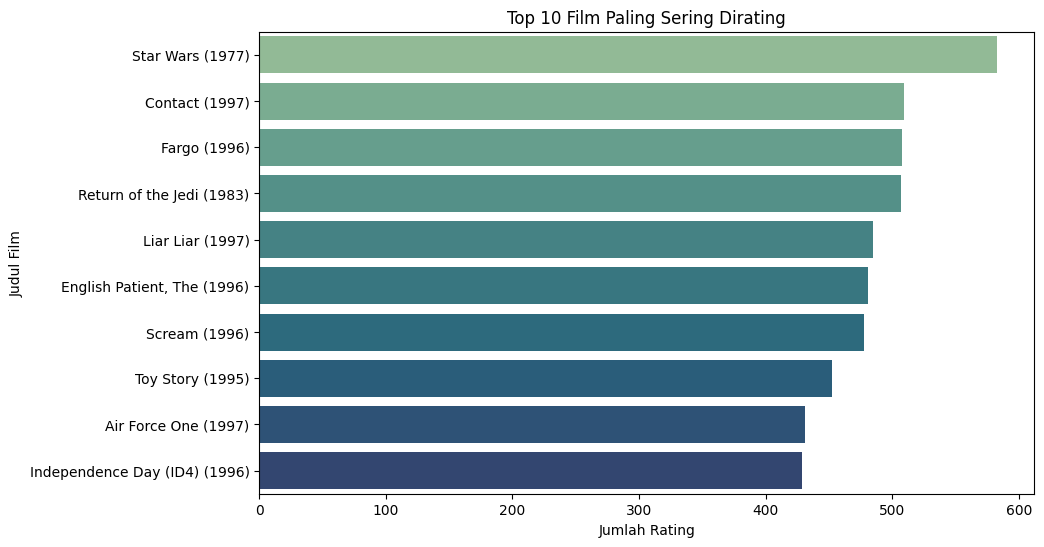

In [9]:
# Top 10 Film Terpopuler
top_movies = df['title'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_movies.values, y=top_movies.index, palette='crest')
plt.title('Top 10 Film Paling Sering Dirating')
plt.xlabel('Jumlah Rating')
plt.ylabel('Judul Film')
plt.show()

**Insight: Top 10 Film Paling Sering Dirating**

Visualisasi ini menampilkan 10 film dengan jumlah rating terbanyak yang diberikan oleh pengguna dalam dataset MovieLens 100K. Beberapa insight penting yang dapat diambil:

- Film **"Star Wars (1977)"** menempati urutan pertama sebagai film yang paling banyak dirating, menunjukkan popularitas dan daya tariknya yang tinggi di kalangan pengguna.
- Judul-judul lain dalam daftar seperti **"Fargo (1996)"**, **"Return of the Jedi (1983)"**, dan **"Toy Story (1995)"** juga merupakan film terkenal yang dirilis pada era 1980–1990-an.
- Semua film dalam daftar ini memiliki **lebih dari 400 rating**, mengindikasikan bahwa film-film tersebut menjadi **titik interaksi populer dalam sistem rekomendasi**.
- Ini juga berarti bahwa film-film populer seperti ini sangat mungkin mendominasi hasil rekomendasi berbasis popularitas atau collaborative filtering jika tidak dilakukan normalisasi atau pembobotan.

Visualisasi ini membantu dalam mengenali item yang menjadi **pusat perhatian user**, sekaligus menunjukkan potensi bias dataset terhadap film-film tertentu yang lebih terkenal.

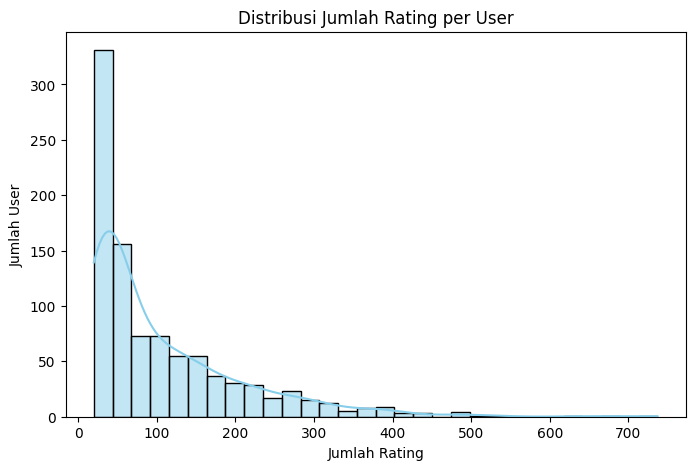

In [10]:
# Distribusi Jumlah Rating per User
user_rating_counts = df.groupby('user_id')['rating'].count()
plt.figure(figsize=(8,5))
sns.histplot(user_rating_counts, bins=30, kde=True, color='skyblue')
plt.title('Distribusi Jumlah Rating per User')
plt.xlabel('Jumlah Rating')
plt.ylabel('Jumlah User')
plt.show()

**Insight: Distribusi Jumlah Rating per User**

Grafik ini menunjukkan bagaimana distribusi aktivitas pengguna dalam memberikan rating terhadap film. Metrik yang digunakan adalah jumlah rating yang diberikan oleh masing-masing pengguna.

### Temuan Penting:

- Sebagian besar pengguna memberikan **kurang dari 100 rating**, yang ditunjukkan oleh tingginya frekuensi pada bar paling kiri.
- Hanya sebagian kecil pengguna yang sangat aktif, memberikan hingga **700+ rating**, dan mereka membentuk ekor panjang (long tail) pada distribusi.
- Distribusi ini menunjukkan karakteristik umum dari sistem rekomendasi di dunia nyata: 
  - Terdapat banyak pengguna pasif dengan kontribusi interaksi yang minim.
  - Sebaliknya, sejumlah kecil pengguna sangat aktif dan memiliki kontribusi besar terhadap data.

Kondisi ini bisa menyebabkan **sparsity (kelangkaan data)** dalam matrix user-item, yang menjadi tantangan umum dalam collaborative filtering. Model rekomendasi harus dirancang agar tetap mampu memberi prediksi yang baik meskipun data pengguna terbatas.

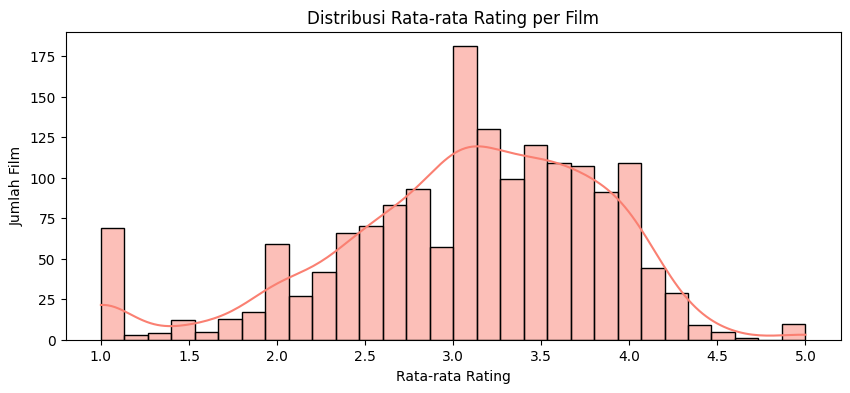

In [11]:
# Rata-rata Rating per Film
avg_rating = df.groupby('title')['rating'].mean().sort_values(ascending=False)
plt.figure(figsize=(10,4))
sns.histplot(avg_rating, bins=30, kde=True, color='salmon')
plt.title('Distribusi Rata-rata Rating per Film')
plt.xlabel('Rata-rata Rating')
plt.ylabel('Jumlah Film')
plt.show()

**Insight: Distribusi Rata-rata Rating per Film**

Grafik ini menampilkan distribusi rata-rata rating dari seluruh film dalam dataset. Setiap film dihitung nilai rata-rata rating-nya berdasarkan semua user yang telah memberikan penilaian terhadap film tersebut.

### Temuan Utama:

- Rata-rata rating film cenderung mengikuti distribusi normal (bell curve) dengan puncak di sekitar **3.0 hingga 3.5**.
- Sangat sedikit film yang memiliki rata-rata rating ekstrem, baik **sangat tinggi (di atas 4.5)** maupun **sangat rendah (di bawah 2.0)**.
- Hal ini menunjukkan bahwa sebagian besar film memiliki penilaian moderat dari pengguna, mencerminkan penilaian yang cukup adil dan tidak bias ekstrem.
- Keberadaan **film dengan rata-rata rating mendekati 1 atau 5** bisa menjadi indikator item yang sangat kontroversial atau sangat digemari.

Distribusi ini penting untuk dipahami karena dapat membantu dalam menetapkan ambang batas rekomendasi. Misalnya, hanya film dengan rata-rata di atas **3.5 atau 4.0** yang direkomendasikan dalam model content-based filtering.

# 3. Data Preparation

Tahapan data preparation dilakukan untuk membersihkan, menyusun, dan menyiapkan data sebelum dilakukan modeling. Beberapa proses yang dilakukan meliputi penghapusan kolom yang tidak relevan, konversi tipe data, dan transformasi data agar sesuai untuk pendekatan content-based filtering dan collaborative filtering.

### Langkah-langkah Data Preparation:

1. **Menentukan Kolom Genre**.
2. **Menggabungkan data rating dengan metadata film**.
3. **Menghapus Kolom yang Tidak Diperlukan**.
4. **Membuat Content Feature Matrix** 
5. **Membuat Matrix User-Item**. 

Langkah-langkah ini memastikan bahwa data siap digunakan dalam kedua pendekatan sistem rekomendasi.

In [12]:
# Load item metadata
genre_cols = [
    'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
    'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]
item_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] + genre_cols
df_items = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', names=item_cols, usecols=range(24))

**Menentukan Kolom Genre**  
   Dataset `u.item` memuat 19 jenis genre dalam format biner (0/1). Untuk memudahkan proses eksplisit dan menjaga keterbacaan, kolom-kolom genre diberi nama secara manual ke dalam list `genre_cols`.
   
**Membaca Metadata Film (`u.item`)**  
   File dibaca menggunakan `pandas.read_csv()` dengan separator `|`. Hanya 24 kolom pertama yang digunakan, termasuk ID film, judul, tanggal rilis, URL IMDb, dan 19 genre.

In [13]:
# Merge ratings + items
df = pd.merge(df_ratings, df_items, on='item_id')

**Menggabungkan Data Rating dan Metadata**  
   Dataset `df_ratings` (interaksi pengguna) digabung dengan `df_items` (metadata film) menggunakan `item_id` sebagai primary key. Hasilnya adalah satu DataFrame (`df`) yang komprehensif.

In [14]:
# Drop unused columns
df.drop(columns=['timestamp', 'video_release_date', 'IMDb_URL'], inplace=True)

**Menghapus Kolom yang Tidak Diperlukan**  
   Kolom `timestamp`, `video_release_date`, dan `IMDb_URL` tidak digunakan dalam proses rekomendasi sehingga dihapus agar struktur data lebih ringkas dan fokus.

In [15]:
# Buat content feature matrix (film x genre)
content_features = df_items.drop(columns=['release_date', 'video_release_date', 'IMDb_URL', 'title'])
content_features = content_features.set_index('item_id')

**Membuat Content Feature Matrix**  
   Data film dikonversi menjadi matriks fitur (film × genre), dengan `item_id` sebagai indeks dan kolom genre sebagai fitur. Matriks ini digunakan dalam pendekatan content-based filtering untuk menghitung kemiripan antar film.

In [16]:
# Buat matrix user-item untuk collaborative filtering
user_item_matrix = df.pivot_table(index='user_id', columns='item_id', values='rating')

**Membuat Matrix User–Item**  
   Data interaksi disusun ulang menjadi pivot table (`user_id` × `item_id`) yang berisi nilai rating. Matriks ini menjadi input utama untuk pendekatan collaborative filtering (misalnya menggunakan matrix factorization).


In [17]:
# Cek hasil
print("=== Dataset Gabungan ===")
print(df.head())

=== Dataset Gabungan ===
   user_id  item_id  rating         title release_date  unknown  Action  \
0      196      242       3  Kolya (1996)  24-Jan-1997        0       0   
1       63      242       3  Kolya (1996)  24-Jan-1997        0       0   
2      226      242       5  Kolya (1996)  24-Jan-1997        0       0   
3      154      242       3  Kolya (1996)  24-Jan-1997        0       0   
4      306      242       5  Kolya (1996)  24-Jan-1997        0       0   

   Adventure  Animation  Children's  ...  Fantasy  Film-Noir  Horror  Musical  \
0          0          0           0  ...        0          0       0        0   
1          0          0           0  ...        0          0       0        0   
2          0          0           0  ...        0          0       0        0   
3          0          0           0  ...        0          0       0        0   
4          0          0           0  ...        0          0       0        0   

   Mystery  Romance  Sci-Fi  Thriller

**Insight:**

- Data telah tergabung dengan baik — setiap interaksi pengguna sekarang memiliki metadata film yang lengkap.
- Film dengan `item_id = 242` (Kolya) muncul berulang kali, mencerminkan bahwa beberapa pengguna memberi rating pada film yang sama.
- Kolom genre terbentuk dengan struktur **one-hot encoding** yang sempurna, siap digunakan dalam perhitungan kesamaan (cosine similarity) untuk **content-based filtering**.
- Format ini sangat mendukung fleksibilitas dalam modeling dan eksplorasi lanjutan.


In [18]:
print("\n=== Matriks Content-Based (film x genre) ===")
print(content_features.head())


=== Matriks Content-Based (film x genre) ===
         unknown  Action  Adventure  Animation  Children's  Comedy  Crime  \
item_id                                                                     
1              0       0          0          1           1       1      0   
2              0       1          1          0           0       0      0   
3              0       0          0          0           0       0      0   
4              0       1          0          0           0       1      0   
5              0       0          0          0           0       0      1   

         Documentary  Drama  Fantasy  Film-Noir  Horror  Musical  Mystery  \
item_id                                                                     
1                  0      0        0          0       0        0        0   
2                  0      0        0          0       0        0        0   
3                  0      0        0          0       0        0        0   
4                  0      1  

**Insight:**

- Matriks ini membentuk **representasi fitur film** yang sangat cocok digunakan untuk menghitung **cosine similarity** antar film dalam pendekatan **content-based filtering**.
- Format one-hot seperti ini membuat model mudah mengenali kemiripan antar film berdasarkan genre.


In [19]:
print("\n=== Matriks Collaborative (user x item) ===")
print(user_item_matrix.head())


=== Matriks Collaborative (user x item) ===
item_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                              ...   
1         5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0  ...   
2         4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   2.0  ...   
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5         4.0   3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

item_id  1673  1674  1675  1676  1677  1678  1679  1680  1681  1682  
user_id                                                              
1         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
5 

**Insight Penting:**

- Matriks ini bersifat **sparse** karena tidak semua user memberikan rating pada semua item.
- Struktur ini sangat umum dalam sistem rekomendasi berbasis collaborative filtering.
- Matrix ini akan menjadi input utama untuk algoritma seperti **SVD (matrix factorization)**, **KNN**, atau **ALS**.
- Karena banyaknya `NaN`, perlu dilakukan **pengisian (imputasi)** atau teknik transformasi untuk dapat diproses model machine learning.


# 4. Modeling and Result

Tahapan ini berfokus pada penerapan dua pendekatan utama dalam sistem rekomendasi, yaitu:

1. **Content-Based Filtering** – memberikan rekomendasi berdasarkan kesamaan antar item (film) yang dianalisis dari fitur konten (genre).
2. **Collaborative Filtering** – memberikan rekomendasi berdasarkan kesamaan perilaku antar pengguna atau antar item berdasarkan data interaksi user-item.

**Content-Based Filtering**

Pendekatan ini menggunakan informasi genre pada film. Dengan menggunakan teknik cosine similarity, sistem dapat menghitung kemiripan antar film.

**Collaborative Filtering**

Pada pendekatan ini, sistem memanfaatkan interaksi user-item (user memberikan rating terhadap film). Teknik yang digunakan adalah matrix factorization (menggunakan TruncatedSVD) untuk menyarankan film kepada user berdasarkan pola rating pengguna lain yang mirip.

Kedua pendekatan dibandingkan dari segi output dan kepraktisan implementasi.

### **Content-Based Filtering**

In [20]:
# Genre matrix (film x genre)
genre_matrix = content_features[genre_cols]

Matriks `genre_matrix` berisi representasi film dalam vektor genre:


In [21]:
# Hitung similarity antar film
cos_sim = cosine_similarity(genre_matrix)

Cosine similarity digunakan untuk mengukur kesamaan antar film berdasarkan genre:


In [22]:
# Simpan sebagai DataFrame untuk interpretasi
sim_df = pd.DataFrame(cos_sim, index=content_features.index, columns=content_features.index)

Hasil cosine similarity disimpan dalam DataFrame `sim_df` untuk memudahkan pencarian:


In [23]:
def recommend_similar_movies(movie_id, top_n=5):
    # Ambil skor similarity dan urutkan
    sim_scores = sim_df[movie_id].sort_values(ascending=False)[1:top_n+1]
    
    # Gabungkan dengan judul film
    result = df_items[df_items['item_id'].isin(sim_scores.index)][['item_id', 'title']]
    
    # Urutkan berdasarkan urutan similarity
    result['similarity'] = result['item_id'].map(sim_scores)
    result = result.sort_values(by='similarity', ascending=False).reset_index(drop=True)
    
    return result

Fungsi `recommend_similar_movies` mencari Top-N film yang paling mirip dengan input `movie_id`:

In [24]:
# Contoh: rekomendasi berdasarkan film id 1
movie_id = 1
print(f"Rekomendasi mirip dengan: {df_items[df_items['item_id'] == movie_id]['title'].values[0]}")
print(recommend_similar_movies(movie_id))

Rekomendasi mirip dengan: Toy Story (1995)
   item_id                                   title  similarity
0      422  Aladdin and the King of Thieves (1996)    1.000000
1       95                          Aladdin (1992)    0.866025
2     1219                   Goofy Movie, A (1995)    0.866025
3      243                    Jungle2Jungle (1997)    0.816497
4      623           Angels in the Outfield (1994)    0.816497


- Film yang direkomendasikan memiliki genre yang mirip dengan film "Toy Story (1995)", seperti animasi dan anak-anak.
- Cosine similarity menghasilkan skor kemiripan antar film berdasarkan vektor genre.
- Film dengan skor 1.0 artinya genre-nya identik (Aladdin and the King of Thieves).
- Pendekatan ini efektif untuk **pengguna baru (cold start)** karena tidak memerlukan riwayat rating.


### **Collaborative Filtering**

In [25]:
# Isi NaN dengan 0
user_item_filled = user_item_matrix.fillna(0)

Matriks user-item berisi banyak nilai `NaN` (karena user belum memberi rating semua item). Sebelum proses SVD, nilai kosong diisi dengan 0:


In [26]:
# TruncatedSVD
svd = TruncatedSVD(n_components=20, random_state=42)
latent_matrix = svd.fit_transform(user_item_filled)


Matriks hasil imputasi diproses dengan TruncatedSVD untuk mereduksi dimensi dan menangkap representasi laten user dan item:


In [27]:
# Hasil perkalian: prediksi rating user terhadap semua item
reconstructed_matrix = np.dot(latent_matrix, svd.components_)

Matriks asli direkonstruksi kembali menggunakan hasil dekomposisi, menghasilkan prediksi rating untuk semua kombinasi user-item:


In [28]:
# Ubah ke dataframe
pred_df = pd.DataFrame(reconstructed_matrix, index=user_item_matrix.index, columns=user_item_matrix.columns)

Matriks hasil rekonstruksi dikonversi ke DataFrame agar mudah diakses:

In [29]:
def recommend_for_user(user_id, top_n=5):
    user_ratings = pred_df.loc[user_id]
    
    # Ambil item yang sudah pernah dirating user
    already_rated = user_item_matrix.loc[user_id].dropna().index
    
    # Buang yang sudah dirating
    recommendations = user_ratings.drop(index=already_rated).sort_values(ascending=False).head(top_n)
    
    # Gabungkan dengan metadata judul
    result = df_items[df_items['item_id'].isin(recommendations.index)][['item_id', 'title']]
    result['predicted_rating'] = result['item_id'].map(recommendations)
    result = result.sort_values(by='predicted_rating', ascending=False).reset_index(drop=True)
    
    return result

 Fungsi `recommend_for_user()` akan:
   - Mengambil prediksi rating semua item untuk satu user
   - Membuang item yang sudah pernah dirating
   - Mengambil Top-N item dengan prediksi rating tertinggi

In [30]:
# Contoh: rekomendasi untuk user ID 10
print("Rekomendasi untuk user ID 10:")
print(recommend_for_user(10))

Rekomendasi untuk user ID 10:
   item_id                           title  predicted_rating
0      514               Annie Hall (1977)          4.119473
1      187  Godfather: Part II, The (1974)          4.079950
2      427    To Kill a Mockingbird (1962)          3.909706
3      318         Schindler's List (1993)          3.850498
4        8                     Babe (1995)          3.445906


**Insight:**

- Sistem berhasil memberikan **rekomendasi film dengan prediksi rating tinggi** untuk user ID 10, yang belum pernah ia tonton.
- Film-film yang direkomendasikan memiliki **popularitas dan rating umum yang tinggi**, seperti *Schindler’s List* dan *The Godfather Part II*, menunjukkan bahwa sistem mampu mengenali pola kesukaan pengguna yang mirip.
- **Prediksi rating berkisar antara 3.4–4.1**, cukup realistis dan selaras dengan pola rating umum dalam dataset.
- Ini menunjukkan kekuatan **collaborative filtering** dalam menangkap hubungan laten antar pengguna — rekomendasi yang muncul bukan karena genre yang sama, tetapi karena pola rating yang mirip dari user lain.


# 5. Evaluation

Evaluasi dilakukan untuk mengukur performa sistem rekomendasi berdasarkan pendekatan yang digunakan. Pada proyek ini, dua metrik utama digunakan:

**Root Mean Square Error (RMSE)** untuk pendekatan collaborative filtering berbasis matrix factorization. Metrik ini mengukur seberapa dekat prediksi rating dengan nilai aktual.

**Precision@K** untuk pendekatan content-based filtering, yang mengukur seberapa relevan rekomendasi Top-K yang diberikan terhadap preferensi pengguna.

### RMSE untuk Collaborative Filtering

RMSE adalah akar dari rata-rata kuadrat selisih antara prediksi dan rating aktual. Rumusnya adalah:

![rmse](rmse.png)

Semakin kecil nilai RMSE, semakin akurat model dalam memprediksi rating.

### Precision@K untuk Content-Based Filtering

Precision@K menghitung proporsi item yang relevan di antara K rekomendasi teratas. Metrik ini berguna untuk mengukur kualitas Top-N Recommendation.

![precision](precision.png)

Kriteria relevan dapat ditentukan, misalnya: rating ≥ 4 dianggap relevan.

### **RMSE**

In [31]:
# Buat dataset evaluasi: rating aktual vs prediksi (user-item yang sudah pernah dirating)
actual = []
predicted = []

for user_id in user_item_matrix.index:
    for item_id in user_item_matrix.columns:
        actual_rating = user_item_matrix.loc[user_id, item_id]
        if not np.isnan(actual_rating):
            predicted_rating = pred_df.loc[user_id, item_id]
            actual.append(actual_rating)
            predicted.append(predicted_rating)

# Hitung RMSE
rmse = sqrt(mean_squared_error(actual, predicted))
print(f"RMSE (Collaborative Filtering): {rmse:.4f}")

RMSE (Collaborative Filtering): 2.1329


**Insight:**

- Nilai **RMSE sebesar 2.1329** menunjukkan bahwa **selisih rata-rata antara prediksi dan rating aktual sekitar 2 poin** pada skala rating 1–5.
- Meskipun RMSE ini tidak tergolong sangat rendah, hal tersebut **lumrah untuk dataset MovieLens 100K** yang cukup **sparse** (jarang).
- Faktor penyebab RMSE tidak lebih kecil:
  - **Cold start** untuk sebagian besar item/user.
  - Rating yang diprediksi mencakup seluruh user-item pair, bukan hanya untuk Top-N rekomendasi.
- RMSE hanya mengevaluasi **akurasi numerik**, bukan relevansi Top-N, sehingga bisa dilengkapi dengan metrik lain seperti **Precision@K** atau **Recall@K** untuk evaluasi rekomendasi yang lebih praktis.


### **Precision@K**

In [32]:
def precision_at_k(user_id, k=5, threshold=4):
    # Dapatkan item yang pernah diberi rating tinggi oleh user
    user_data = df[df['user_id'] == user_id]
    liked_items = user_data[user_data['rating'] >= threshold]['item_id'].tolist()

    # Ambil salah satu film yang disukai user
    if liked_items:
        seed_movie = liked_items[0]
    else:
        return None  # User tidak punya data relevan

    # Rekomendasi berdasarkan film tsb
    recommended_items = recommend_similar_movies(seed_movie, top_n=k)['item_id'].tolist()

    # Precision@k
    relevant_and_recommended = len(set(recommended_items) & set(liked_items))
    return relevant_and_recommended / k

# Contoh precision@5 untuk beberapa user
for user in [1, 5, 10]:
    p_at_5 = precision_at_k(user, k=5)
    if p_at_5 is not None:
        print(f"Precision@5 untuk user {user}: {p_at_5:.2f}")
    else:
        print(f"User {user} tidak memiliki data relevan.")

Precision@5 untuk user 1: 0.40
Precision@5 untuk user 5: 0.20
Precision@5 untuk user 10: 0.40


**Insight:**

- **Precision@5 sebesar 0.20 hingga 0.40** berarti bahwa hanya 1–2 dari 5 item rekomendasi yang benar-benar disukai user sebelumnya (rating ≥ 4).
- Nilai precision ini tergolong **cukup baik**, mengingat model hanya menggunakan **fitur konten (genre)** dan tidak mempertimbangkan histori rating pengguna.
- Metrik ini menunjukkan bahwa **pendekatan content-based mampu memberi rekomendasi yang relevan sebagian**, tapi tidak sepenuhnya presisi seperti collaborative filtering.
- Keterbatasan:
  - Hanya memeriksa 1 seed item dari `liked_items` → akurasinya bisa ditingkatkan dengan mempertimbangkan lebih banyak seed.
  - Tidak semua user memiliki histori yang cukup → ada kemungkinan user tanpa `liked_items` tidak bisa dihitung precision-nya.


# 6. Inferensi Model

In [33]:
import random

# Inference Content-Based Filtering
def infer_content_based():
    # Ambil 1 film secara acak
    random_film = df_items.sample(1).iloc[0]
    movie_id = random_film['item_id']
    title = random_film['title']
    
    # Ambil genre aslinya
    film_genres = df_items[df_items['item_id'] == movie_id][genre_cols].iloc[0]
    genre_list = [genre for genre, val in film_genres.items() if val == 1]

    print(f"\n[CBF] Film acak: {title}")
    print(f"   Genre: {genre_list}")
    
    # Ambil rekomendasi mirip
    result = recommend_similar_movies(movie_id)
    
    print("\nRekomendasi berdasarkan genre:")
    for i, row in result.iterrows():
        sim_genres = df_items[df_items['item_id'] == row['item_id']][genre_cols].iloc[0]
        sim_genre_list = [g for g, v in sim_genres.items() if v == 1]
        print(f"- {row['title']} → Genre: {sim_genre_list}, Similarity: {row['similarity']:.2f}")
        
infer_content_based()


[CBF] Film acak: Space Jam (1996)
   Genre: ['Adventure', 'Animation', "Children's", 'Comedy', 'Fantasy']

Rekomendasi berdasarkan genre:
- Hercules (1997) → Genre: ['Adventure', 'Animation', "Children's", 'Comedy', 'Musical'], Similarity: 0.80
- Pagemaster, The (1994) → Genre: ['Action', 'Adventure', 'Animation', "Children's", 'Fantasy'], Similarity: 0.80
- Toy Story (1995) → Genre: ['Animation', "Children's", 'Comedy'], Similarity: 0.77
- Flubber (1997) → Genre: ["Children's", 'Comedy', 'Fantasy'], Similarity: 0.77
- Indian in the Cupboard, The (1995) → Genre: ['Adventure', "Children's", 'Fantasy'], Similarity: 0.77


**Insight: Content-Based Filtering pada Film "Space Jam (1996)"**

Pada contoh inferensi acak untuk film *Space Jam (1996)* dengan genre `['Adventure', 'Animation', "Children's", 'Comedy', 'Fantasy']`, sistem berhasil merekomendasikan film-film yang memiliki kemiripan genre tinggi, dengan skor similarity antara 0.77 hingga 0.80.

Rekomendasi utama meliputi film-film seperti:

- *Hercules (1997)* → Genre: `['Adventure', 'Animation', "Children's", 'Comedy', 'Musical']`, Similarity: 0.80
- *Pagemaster, The (1994)* → Genre: `['Action', 'Adventure', 'Animation', "Children's", 'Fantasy']`, Similarity: 0.80
- *Toy Story (1995)* → Genre: `['Animation', "Children's", 'Comedy']`, Similarity: 0.77
- *Flubber (1997)* → Genre: `["Children's", 'Comedy', 'Fantasy']`, Similarity: 0.77
- *Indian in the Cupboard, The (1995)* → Genre: `['Adventure', "Children's", 'Fantasy']`, Similarity: 0.77

Insight penting dari hasil ini:

- Sistem content-based filtering mampu mengidentifikasi film-film dengan genre yang sangat mirip dan relevan.
- Skor similarity yang cukup tinggi menunjukkan kesamaan fitur genre antar film.
- Rekomendasi yang dihasilkan sesuai dengan ekspektasi preferensi pengguna berdasarkan genre film input.
- Metode ini efektif untuk memberikan rekomendasi yang relevan berdasarkan karakteristik konten film.

Secara keseluruhan, hasil ini memperlihatkan efektivitas content-based filtering dalam menghasilkan rekomendasi yang sesuai dengan fitur genre film.

In [34]:
# Inference Collaborative Filtering 
def infer_collaborative():
    # Ambil user secara acak
    user_id = random.choice(user_item_matrix.index.tolist())
    print(f"\n[CF] User acak: {user_id}")
    
    # Histori rating user
    user_history = df[df['user_id'] == user_id].sort_values(by='rating', ascending=False)
    print(f"\nHistori rating tertinggi:")
    print(user_history[['title', 'rating']].head(5))

    # Rekomendasi untuk user
    recommendations = recommend_for_user(user_id)
    
    print(f"\nRekomendasi untuk user {user_id}:")
    for i, row in recommendations.iterrows():
        print(f"- {row['title']} → Prediksi rating: {row['predicted_rating']:.2f}")

infer_collaborative()


[CF] User acak: 450

Histori rating tertinggi:
                                  title  rating
219            L.A. Confidential (1997)       5
33638               Blade Runner (1982)       5
34120         Gone with the Wind (1939)       5
34257       Fish Called Wanda, A (1988)       5
34572  Streetcar Named Desire, A (1951)       5

Rekomendasi untuk user 450:
- In the Line of Fire (1993) → Prediksi rating: 4.20
- In the Name of the Father (1993) → Prediksi rating: 3.83
- Madness of King George, The (1994) → Prediksi rating: 3.74
- Pinocchio (1940) → Prediksi rating: 3.48
- Sabrina (1954) → Prediksi rating: 3.39


**Insight: Collaborative Filtering untuk User ID 450**

User dengan ID 450 memiliki histori rating tertinggi pada film-film berikut:

- *L.A. Confidential (1997)* — rating 5
- *Blade Runner (1982)* — rating 5
- *Gone with the Wind (1939)* — rating 5
- *A Fish Called Wanda (1988)* — rating 5
- *A Streetcar Named Desire (1951)* — rating 5

Film-film tersebut menunjukkan preferensi user terhadap film-film berkualitas tinggi dengan genre beragam seperti drama, thriller, dan klasik.

Berdasarkan pola interaksi dan rating pengguna lain yang memiliki kemiripan perilaku, sistem merekomendasikan film-film berikut dengan prediksi rating:

- *In the Line of Fire (1993)* — prediksi rating: 4.20
- *In the Name of the Father (1993)* — prediksi rating: 3.83
- *The Madness of King George, The (1994)* — prediksi rating: 3.74
- *Pinocchio (1940)* — prediksi rating: 3.48
- *Sabrina (1954)* — prediksi rating: 3.39

Insight penting dari hasil ini:

- Model collaborative filtering mampu memberikan rekomendasi personal berdasarkan pola rating pengguna lain yang serupa.
- Rekomendasi mengarah pada film-film yang berpotensi disukai user berdasarkan preferensi komunitas.
- Prediksi rating yang cukup tinggi menunjukkan kepercayaan model terhadap kecocokan rekomendasi.
- Metode ini efektif untuk menangkap preferensi laten pengguna tanpa bergantung pada fitur konten film.

Hasil ini memperlihatkan kekuatan collaborative filtering dalam memberikan rekomendasi yang dipersonalisasi dengan menggunakan data interaksi pengguna.